Project Proposal- Predicting The Occurrence of Exercised Induced-Angina by Analysis of Blood Pressure and Maximum Heart Rate

Preliminary exploratory data analysis:

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

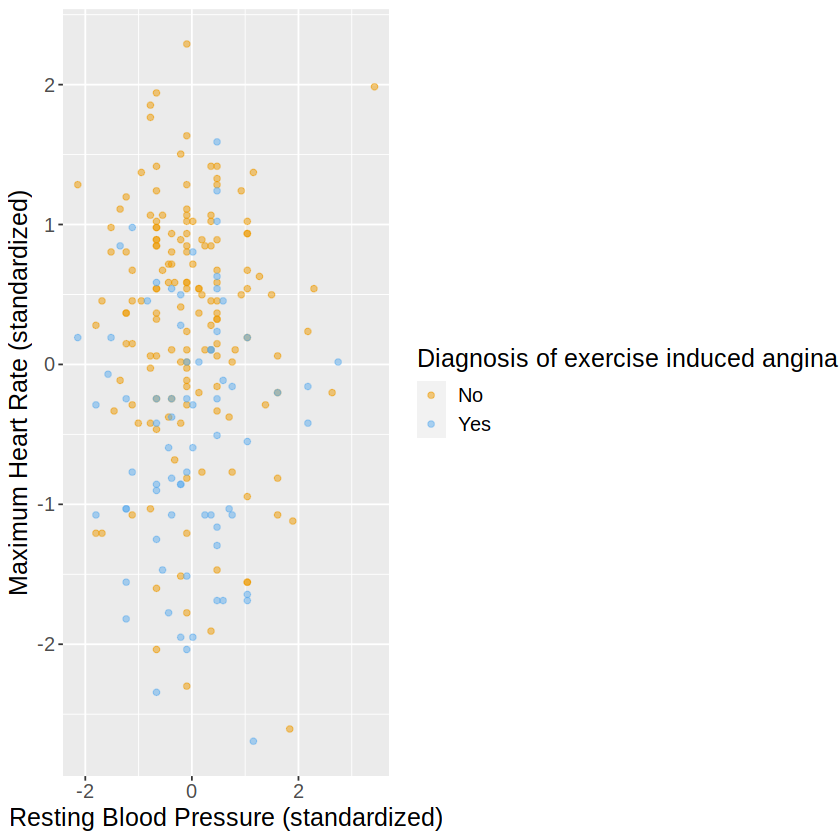

In [1]:
library(tidyverse)
library(tidymodels)


url<- "https://raw.githubusercontent.com/elaines6/dsci-100-group-project/main/processed.cleveland.data"
heart_raw_data <- read_csv(url, col_names = c("age", "sex", "chest_pain_type", "resting_bp", "chol", "fasting_bs", "rest_ecg", "max_rate",
                                             "exercise_induced_angina", "ST_depression", "slope_peak_exercise", "major_vessels", "thal", "diagnosis_heart_disease"))
heart_data_tidy <- heart_raw_data |>
    mutate(sex = as_factor(sex), chest_pain_type = as_factor(chest_pain_type), exercise_induced_angina = as_factor(exercise_induced_angina)) |>
    mutate(sex = fct_recode(sex, "Female" = "0", "Male" = "1")) |>
    mutate(exercise_induced_angina = fct_recode(exercise_induced_angina, "Yes" = "1", "No" = "0")) |>
    mutate(chest_pain_type = fct_recode(chest_pain_type, "Typical angina" = "1", "Atypical angina" = "2", "Non-anginal pain" = "3", "Asymptomatic" = "4")) |>
    filter(age != "?" & sex != "?"& chest_pain_type != "?"& resting_bp != "?"& max_rate!= "?"& exercise_induced_angina != "?")

unscaled_heart_data <- heart_data_tidy |>
    select(resting_bp, max_rate, exercise_induced_angina) |>
    mutate(resting_bp = as.integer(resting_bp), max_rate = as.integer(max_rate))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |> 
    set_engine("kknn") |> 
    set_mode("classification") 

heart_data_recipe <- recipe(exercise_induced_angina ~ resting_bp + max_rate, data = unscaled_heart_data)

heart_data_recipe <- heart_data_recipe |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

scaled_heart_data <- bake(heart_data_recipe, unscaled_heart_data)


heart_data_split <- initial_split(scaled_heart_data, prop = 0.75, strata = exercise_induced_angina)
heart_data_train <- training(heart_data_split)
heart_data_test <- testing(heart_data_split) 

heart_plot<- heart_data_train|>
    ggplot(aes(x= resting_bp, y= max_rate, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "Resting Blood Pressure (standardized)", 
         y= "Maximum Heart Rate (standardized)",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot

In [2]:
#one that reports the number of observations in each class

scaled_heart_data |>
    group_by(exercise_induced_angina)|>
    summarize(count = n())


exercise_induced_angina,count
<fct>,<int>
No,204
Yes,99


In [3]:
#mean of predictors
predictors_of_heart_data<- scaled_heart_data|>
    select(max_rate, resting_bp)
mean_of_columns<- colMeans(predictors_of_heart_data)
mean_of_columns

frame_of_mean <- tibble( row.names=c('max_rate','resting_bp'),
                      mean_of_columns)
frame_of_mean

max_rate    resting_bp 
-3.693415e-16 -2.843343e-16

row.names,mean_of_columns
<chr>,<dbl>
max_rate,-3.693415e-16
resting_bp,-2.843343e-16


Introduction

Background Information

Angina is categorized as a type of chest pain due to a reduced blood flow to the heart. Specific to this project, exercise induced angina is being analyzed and predicted. Exercise induced angina is a distinct class of angina, as the symptoms only occur when triggered by exercise. When the body is at rest, there is a lower demand of oxygen, allowing the heart to properly function despite the limiting amount of blood flow, with the absence of angina symptoms. Whereas, during exercise, the body will have an increased demand of oxygen, and thus blood flow. However, in this case, the heart is unable to function with the lack of oxygen, without experiencing chest pain sensations, or angina symptoms. Lower blood pressure indicates that the body is not receiving enough blood. Studies have shown that lower blood pressure is typically associated with angina, as it leads to a shortness of breath or chest pain sensations as a result of inadequate oxygen supply. There is also a correlation between abnormal heart rhythms, which would be a very elevated heart rate or a heart rate that is not regular, and angina. Therefore a max heart rate of an abnormal amount would be a tell tale sign of angina.


Predictive Question: Will the individual experience exercise induced angina? 

We are using the data base called heart disease cited as:
Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

Methods 

To conduct our data analysis we will be using the variable/columns: max heart rate and resting blood pressure to make predictions about exercise induced angina.

Visualization through the use of plotting standardized data and using knn classification model to determine the k nearest neighbors and determine class prediction based on majority rules.

Expected outcomes and significance

What do you expect to find?
In this project, resting blood pressure and maximum heart rate will be the two predictors used in classifying an unknown observation into the category of whether the individual will experience exercise induced angina or not. 

What impact could such findings have? 
Findings would be able to predict whether or not individuals will experience exercise induced angina based on their resting blood pressure and maximum heart rate 

What future questions could this lead to?
What other predictors could be used to accurately predict whether an individual will exercise induced angina 
Can exercise induced angina be a predictor for further underlying cardiac health issues (if an individual experiences exercise induced angina, are they at a higher risk for cardiac arrest, stroke, and other complications?)

